In [471]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

#Didnt find much help with Scaling
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
!pip install xgboost
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, make_scorer,r2_score

# Hyperopt imports
!pip install hyperopt
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp

**Read the csv file and observe data**

In [341]:
house = pd.read_csv('kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [342]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


Above, we can see that date is an object. Maybe it is better to change this to integer for better results. Unclear why it has 'T000000' appended to the end. We could remove the same as well

In [343]:
house['date']=house['date'].str.replace('T000000','').astype(int)

Let us find if house has any null values so we could handle the same.

In [344]:
house.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Great! It does not have any null values. Let us plot the histogram just to see if any feature catches our atention

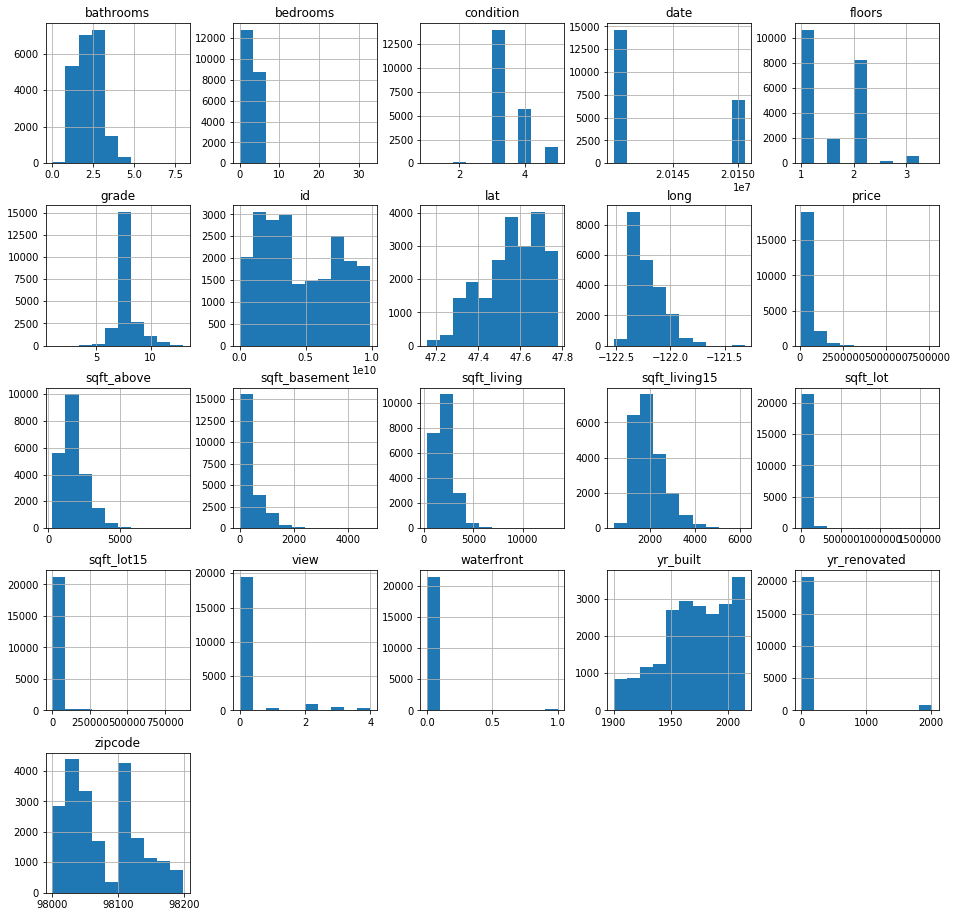

In [345]:
house.hist(figsize=[16,16]);

**A heatmap to understand the co-relation**

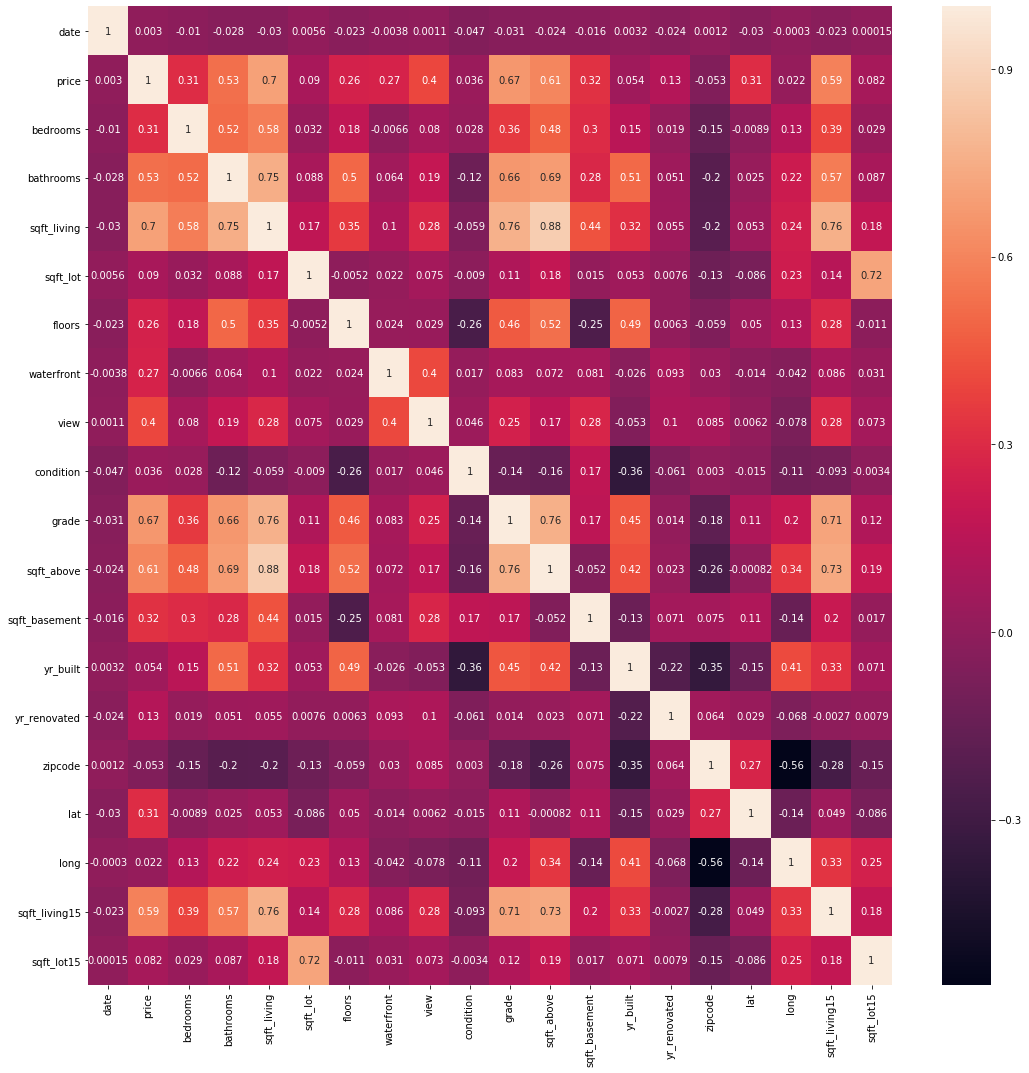

In [346]:
plt.figure(figsize=(18, 18))
sns.heatmap(house.drop("id",axis=1).corr(),annot=True);

Looking at co-relation values of 'price' against other columns, we see that both zipcode and date have values less than 0.01. Let us try to understand the relationship a little deeper

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'date')]

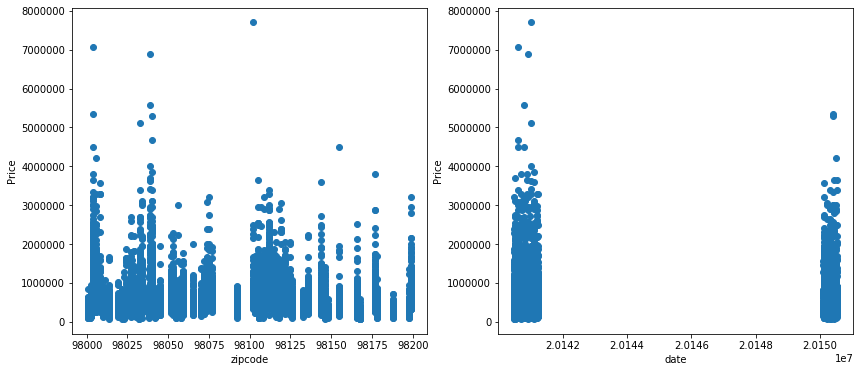

In [468]:
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(1,2,1)
ax.scatter(house['zipcode'],house['price']);
ax.set(xlabel='zipcode',ylabel='Price')

ax=fig.add_subplot(1,2,2)
ax.scatter(house['date'],house['price']);
ax.set(xlabel='date',ylabel='Price')

It looks like date and zipcode are not necessarily linear with price. Probably these columns can be eliminated in our data.

Create X and y values from data and create a 70:30 split to form train vs test data

In [348]:
X = house.drop(['id','price','zipcode','date'],axis=1)
y = house['price']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

**Scoring of models**
We will be capturing both r2 and mse values of each trial. So we initialize r2 and mse global variables. In future we will have a DataFrame to capture model name, r2, mse, test values etc.

In [453]:
r2_global=-1
mse_global=-1

In [ ]:
scorer = {'r2': 'r2', 'MSE': make_scorer(mean_squared_error)}

We will a wrapper on cross_validate to generalize for all models.

In [441]:
def custom_cross_val(params):
    t = params['type']
    del params['type']
    if t == 'linear':
        clf = LinearRegression(**params)
    elif t == 'lasso':
        clf = Lasso(**params)
    elif t == 'ridge':
        clf = Ridge(**params)
    elif t == 'decision':
        clf = DecisionTreeRegressor(**params)
    elif t == 'rf':
        clf = RandomForestRegressor(**params)    
    elif t == 'XGB':
        clf = XGBRegressor(**params)
    else:
        return 0
    return cross_validate(clf, X_train, y_train,scoring=scorer, cv=5)

We use hyperopt to identify values of certain hyper parameters. Hence we define a method called optimize to call the cross validation function. We also track r2 and mse values in global to identify the best scorer

In [448]:
 def optimize(params):
    global r2_global
    global mse_global
    hyperopt_scorer = custom_cross_val(params)
    
    if hyperopt_scorer['test_r2'].mean()>r2_global:
        r2_global = hyperopt_scorer['test_r2'].mean()
        mse_global = hyperopt_scorer['test_MSE'].mean()
    return {'loss': -r2, 'status': STATUS_OK}

call_fmin is wrapper on fmin. It initializes global values and Trials, and prints output

In [455]:
def call_fmin(params):
    trials = Trials()
    global r2_global
    global mse_global
    
    r2_global = -1
    mse_global=-1
    
    fit = fmin(optimize, params, algo=tpe.suggest,
                trials=trials,
                max_evals=100)

    print(fit)
    print(r2_global)
    print(mse_global)

In [497]:
def fit_and_graph(params):
    t = params['type']
    
    del params['type']
    if t == 'linear':
        clf = LinearRegression(**params)
    elif t == 'lasso':
        clf = Lasso(**params)
    elif t == 'ridge':
        clf = Ridge(**params)
    elif t == 'decision':
        clf = DecisionTreeRegressor(**params)
    elif t == 'rf':
        clf = RandomForestRegressor(**params)    
    elif t == 'XGB':
        clf = XGBRegressor(**params)
    else:
        return 0
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("r2 :",r2_score(y_test,y_pred))
    print("mse :",mean_squared_error(y_test,y_pred))
    plt.figure(figsize=(10,6))
    plt.scatter(y_test,y_pred);
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r',lw=4);

space defines the hyper parametrs that we want to evaluate. Each model is run using call_fmin. In future, we will define a single run for all models and capture all output in a dataframe.

**Linear Regression (OLS**

In [456]:
#Primitive OLS
space = {
    "type": "linear",
    "fit_intercept":hp.choice('fit_intercept',[True,False]),
    "normalize":hp.choice('normalize',[True,False])
}

call_fmin(space)

100%|██████████| 100/100 [00:06<00:00, 16.81it/s, best loss: -0.6816928079097367]
{'fit_intercept': 1, 'normalize': 0}
0.6948993648700658
39572565513.19676


r2 : 0.6929376016563503
mse : 45312038342.58452


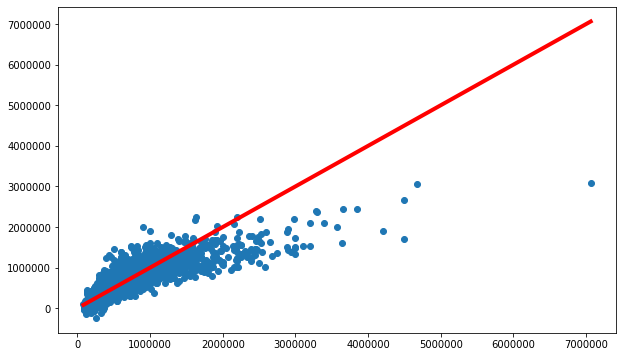

In [498]:
params = {
    'type':'linear',
    'fit_intercept':True,
    'normalize':False}
fit_and_graph(params)

**Lasso (L1 regularization)**

In [457]:
space = {
    "type": "lasso",
    "alpha":hp.choice('alpha',[1e-2,1e-1,0.5,1.0])
}
call_fmin(space)

100%|██████████| 100/100 [03:29<00:00,  2.31s/it, best loss: -0.6816928079097367]
{'alpha': 1}
0.694899364178137
39572565461.752884


r2 : 0.6929375486573897
mse : 45312046163.44097


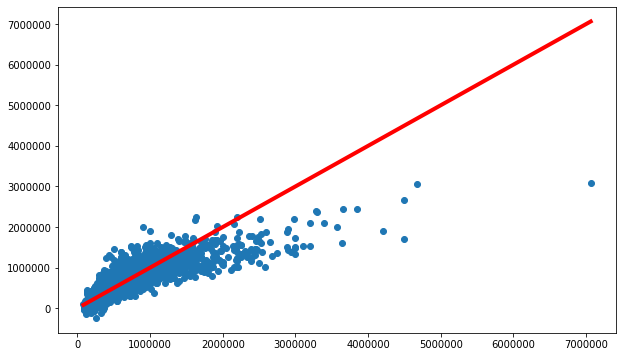

In [499]:
params={
    'type':'lasso',
    'alpha':1e-1
}
fit_and_graph(params)

**Ridge (L2 regularization)**

In [458]:
space = {
    "type": "ridge",
    "alpha":hp.choice('alpha',[1e-11,1e-10,1e-9,1e-8]),
    "fit_intercept":hp.choice('fit_intercept',[True,False]),
    "normalize":hp.choice('normalize',[True,False])
}
call_fmin(space)

100%|██████████| 100/100 [00:06<00:00, 15.57it/s, best loss: -0.6816928079097367]
{'alpha': 1, 'fit_intercept': 1, 'normalize': 0}
0.6948993648803778
39572565512.33012


r2 : 0.6856979547883546
mse : 46380365686.59967


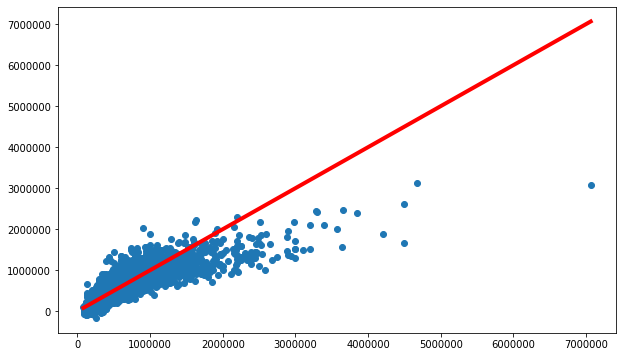

In [500]:
params={
    'type':'ridge',
    'alpha':1e-10,
    'fit_intercept':False,
    'normalize':True
}
fit_and_graph(params)

**Decision Tree**

In [506]:
space = {
    "type": "decision",
    "max_depth":hp.choice('max_depth',range(1,11)),
    "min_samples_leaf":hp.choice('min_samples_leaf',[1, 2, 5, 10]),
    "min_samples_split":hp.choice('min_samples_split',[2, 5, 10,15,100]),
    "max_features":hp.choice('max_features',['auto','sqrt','log2'])
}
call_fmin(space)

100%|██████████| 100/100 [00:16<00:00,  6.12it/s, best loss: -0.6816928079097367]
{'max_depth': 6, 'max_features': 0, 'min_samples_leaf': 0, 'min_samples_split': 1}
0.7863062448924606
27478376265.483646


r2 : 0.7735120252959522
mse : 33421974977.342144


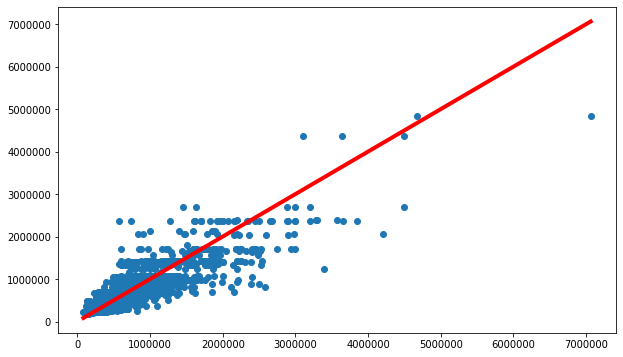

In [507]:
params={
    'type':'decision',
    'max_depth':7,
    'min_samples_leaf':1,
    'min_samples_split':5,
    'max_features': 'auto'
}
fit_and_graph(params)

**Random Forest**

In [464]:
space = {
    "type": "rf",
    "n_estimators":hp.choice('n_estimators',[200]),
    "max_depth":hp.choice('max_depth',[10,11,12,13,14]),
    "min_samples_leaf":hp.choice('min_samples_leaf',[1, 2]),
    "min_samples_split":hp.choice('min_samples_split',[7, 9,10,11])
}
call_fmin(space)

100%|██████████| 100/100 [1:31:48<00:00, 49.97s/it, best loss: -0.6816928079097367]
{'max_depth': 1, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 0}
0.8682883036191107
17065378287.422367


r2 : 0.8747768706605831
mse : 18478704226.285233


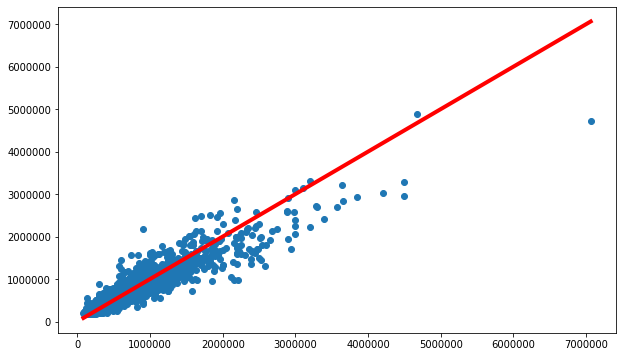

In [502]:
params={
    'type':'rf',
    'max_depth':11,
    'min_samples_leaf':1,
    'min_samples_split':10,
    'n_estimators': 200
}
fit_and_graph(params)

**XGBoost**

In [465]:
space = {
    "type": "XGB",
    #"max_depth":hp.choice('max_depth',[3,5,7]),
    "max_depth":hp.choice('max_depth',[6,7,8]),
    #"learning_rate":hp.choice('learning_rate',[0.06,0.07,0.08,0.09,1]),
    "learning_rate":hp.choice('learning_rate',[0.09]),
    #"min_child_weight":hp.choice('min_child_weight',[1,2,3]),
    "min_child_weight":hp.choice('min_child_weight',[1]),
    "n_estimators":hp.choice('n_estimators',[500]),
    "objective":hp.choice('objective',['reg:squarederror'])
    
}
call_fmin(space)

100%|██████████| 100/100 [1:36:32<00:00, 54.25s/it, best loss: -0.6816928079097367]
{'learning_rate': 0, 'max_depth': 1, 'min_child_weight': 0, 'n_estimators': 0, 'objective': 0}
0.8907326542838007
14102237559.395649


r2 : 0.8965942995540808
mse : 15259188649.348993


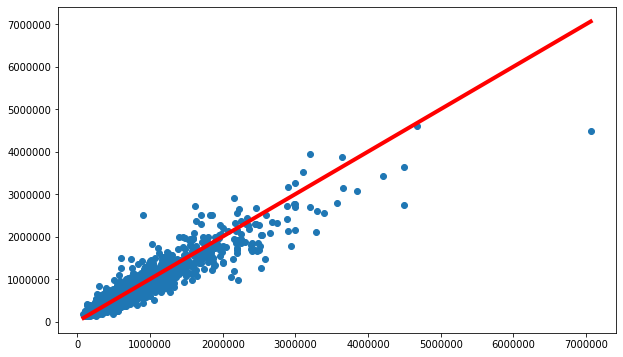

In [505]:
params={
    'type':'XGB',
    'max_depth':7,
    'learning_rate':0.09,
    'min_child_weight':1,
    'n_estimators': 500,
    'objective':'reg:squarederror'
}
fit_and_graph(params)